In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
import altair as alt 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'item_categories.csv', 'sales_train.csv', 'sample_submission.csv', 'items.csv', 'shops.csv']


# 讀取資料

In [2]:
train = pd.read_csv('../input/sales_train.csv')
items = pd.read_csv('../input/items.csv')
categories = pd.read_csv('../input/item_categories.csv')
shops = pd.read_csv('../input/shops.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

# EDA (探索性資料分析, Exploratory Data Analysis)

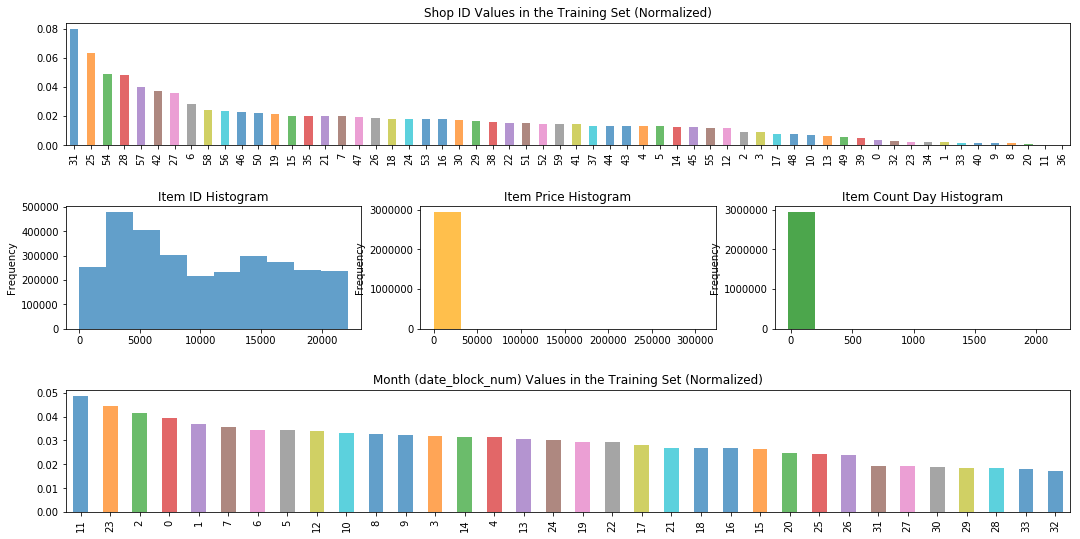

In [3]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
train['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

透過上面各張圖有以下發現:
1. 第一張圖可看到，共有60個shop_id，光是前四名的商店(不到7%的商店)就已經占據了全部資料約25%，這顯示出數據是不平均的。
2. 'item_price'和'item_cnt_day'的直方圖中，右邊有很大的空白區域，代表可能存在異常值，需要做一些處理。
3. date_block_num的圖中，第11個月(也就是2013年12月)的銷售數量最多，其次是第23個月（也就是2014年12月），同樣都是12月。

# 異常值處理

## 首先，檢查item_cnt_day
以item_cnt_day做排序，查看每日銷售量最高的幾個商品

In [4]:
train.sort_values(ascending=False,by='item_cnt_day').head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2864235,30.09.2015,32,12,9248,1692.526158,669.0
2851091,30.09.2015,32,55,9249,1702.825746,637.0
2608040,14.04.2015,27,12,3731,1904.548077,624.0


上方結果顯示有兩筆銷售紀錄非常突出，item_id 11373和20949這兩個商品的每日銷售量最大，銷售量分別是2169和1000，底下來看一下是哪兩個商品:

In [5]:
items.loc[(items.item_id==11373) | (items.item_id==20949)]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


item_id 11373 是指「**運送服務**」，其所屬類別為9，20949則是「**塑膠袋**」，類別為71，下方我們來看一下這兩個類別分別是什麼。

In [6]:
categories.loc[(categories['item_category_id']==9) | (categories['item_category_id']==71)]

,item_category_name,item_category_id
9,Доставка товара,9
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71


透過翻譯得知，運送服務的9號類別是指「**交貨**」、塑膠袋的71號類別則是「**禮品-包，相冊，鼠標墊**」(大概是包裝的意思)

由於「交貨」的銷售量遠超過其他商品銷售次數，有可是離群值，因此我們來看一下「運送服務」的平均值、中位數

In [7]:
print('「運送服務」銷售量的中位數:')
print(train['item_cnt_day'].loc[train['item_id']==11373].median())
print('「運送服務」銷售量的平均數:')
print(train['item_cnt_day'].loc[train['item_id']==11373].mean())

「運送服務」銷售量的中位數:
4.0
「運送服務」銷售量的平均數:
14.144396551724139


以上可知，「運送服務」多半的銷售量都很少，卻在2015.10.28這天出現2169次的銷售量，確實是為一個離群值，故應去除。

In [8]:
train = train[train['item_cnt_day'] < 2000]

### 接下來，檢查item_price
首先檢查最大值

In [9]:
train.sort_values(ascending=False,by='item_price').head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0
885138,17.09.2013,8,12,11365,59200.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0
2327159,29.01.2015,24,12,7241,49782.0,1.0
2931380,20.10.2015,33,22,13403,42990.0,1.0


發現也有一個離群值，item_id為6066，其價格為304980，故需深入檢查一下狀況:

In [10]:
items[items['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


透過翻譯查詢得知，item_id 6066是指 Radmin 3 這套軟體 一次賣給了522個人。
接著我們再來看看有沒有其他這樣的交易:

In [11]:
train[train['item_id']==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


發現，整份訓練資料當中，就只有這麼一筆 item_id 6066的交易，因此可以予以刪除

In [12]:
train = train[train['item_price'] < 300000]

接著也檢查一下item_price的最小值看看是否有離群值

In [13]:
train.sort_values(ascending=True,by='item_price').head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0000,1.0
608763,08.06.2013,5,58,11865,0.0700,1.0
579766,11.06.2013,5,6,11864,0.0700,1.0
611400,08.06.2013,5,58,20146,0.0875,4.0
673155,31.07.2013,6,6,11872,0.0900,1.0


上方結果可發現，item_id 2973 的 item_price出現-1，這可能是一個錯誤值，我們看一下這是什麼商品:

In [14]:
items[items['item_id'] == 2973]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19


是「惡魔獵人」遊戲片，我們繼續詳細檢查，看看有沒有其他item_price也是-1的交易紀錄:

In [15]:
train[train['item_price'] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


發現沒有其他item_price為-1的紀錄，我們接著再看看其他這個商品的交易紀錄:

In [16]:
train[train['item_id'] == 2973].head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,15.01.2013,0,25,2973,2499.0,13.0
353,16.01.2013,0,25,2973,2499.0,5.0
354,17.01.2013,0,25,2973,2499.0,3.0
355,18.01.2013,0,25,2973,2499.0,2.0
356,19.01.2013,0,25,2973,2499.0,3.0


可以看到，這個商品的其他價格都相當高，故可以考慮用中位數來代替這個-1的價格，但我們應該使用同一個店家的價格來做替代，故我們查看一下同樣是shop_id 32的這項商品的其他售價:

In [17]:
train.loc[(train.item_id==2973) & (train.shop_id==32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,29.01.2013,0,32,2973,2499.0,1.0
67428,25.01.2013,0,32,2973,2499.0,1.0
67429,22.01.2013,0,32,2973,2499.0,1.0
67430,21.01.2013,0,32,2973,2499.0,1.0
67431,18.01.2013,0,32,2973,2499.0,1.0
67432,17.01.2013,0,32,2973,2499.0,1.0
67433,15.01.2013,0,32,2973,2499.0,3.0
187844,05.02.2013,1,32,2973,2499.0,1.0
187845,14.02.2013,1,32,2973,2499.0,1.0
484682,23.05.2013,4,32,2973,1249.0,1.0


確實，這個商品在同一店家的其他售價都是正常的，我們使用同一個月內的中位數來替換-1:

In [18]:
new_price = train[(train['shop_id'] == 32) & (train['item_id'] == 2973) & (train['date_block_num'] == 4) & (train['item_price'] > 0)].item_price.median()
train.loc[train['item_price'] < 0, 'item_price'] = new_price

接下來對測試資料進行一些觀察

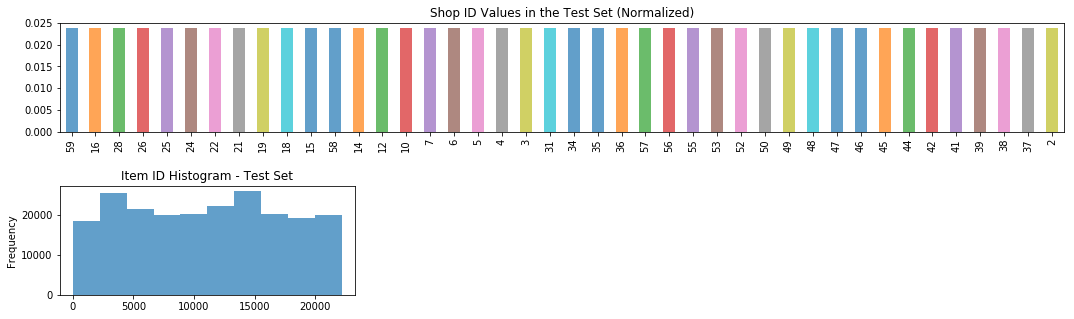

In [19]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
test['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Test Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
test['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram - Test Set')

plt.show()

上方顯示，測試資料的分布較為平均，但是Shop_ID比訓練資料還要少，代表有些商店僅在訓練資料有出現，而沒有出現在測試資料，下方我們來看一下，訓練與測試資料中，出現的商店數量之差異:

In [20]:
shops_train = train['shop_id'].nunique()
shops_test = test['shop_id'].nunique()
print('訓練資料中的商店個數: ', shops_train)
print('測試資料中的商店個數: ', shops_test)

訓練資料中的商店個數:  60
測試資料中的商店個數:  42


接著做一些資料處理、Feature Engineering

In [21]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

In [22]:
cities = shops['shop_name'].str.split(' ').map(lambda row: row[0])
cities.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [23]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda row: row[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit_transform(shops['city'])

array([29, 29,  0,  1,  2,  3,  4,  4,  4,  5,  6,  6,  7,  8,  8,  9, 10,
       11, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14,
       15, 15, 16, 16, 17, 18, 18, 18, 19, 19, 20, 20, 21, 22, 23, 24, 24,
       24, 25, 25, 26, 27, 28, 29, 29, 30])

In [25]:
shops['city_label'] = le.fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis = 1, inplace = True)
shops.head()

,shop_id,city_label
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [26]:
le = preprocessing.LabelEncoder()

main_categories = categories['item_category_name'].str.split('-')
categories['main_category_id'] = main_categories.map(lambda row: row[0].strip())
categories['main_category_id'] = le.fit_transform(categories['main_category_id'])

# Some items don't have sub-categories. For those, we will use the main category as a sub-category
categories['sub_category_id'] = main_categories.map(lambda row: row[1].strip() if len(row) > 1 else row[0].strip())
categories['sub_category_id'] = le.fit_transform(categories['sub_category_id'])

In [27]:
train['date'] =  pd.to_datetime(train['date'], format='%d.%m.%Y')

In [28]:
from itertools import product
shops_in_jan = train.loc[train['date_block_num']==0, 'shop_id'].unique()
items_in_jan = train.loc[train['date_block_num']==0, 'item_id'].unique()
jan = list(product(*[shops_in_jan, items_in_jan, [0]]))

In [29]:
shops_in_feb = train.loc[train['date_block_num']==1, 'shop_id'].unique()
items_in_feb = train.loc[train['date_block_num']==1, 'item_id'].unique()
feb = list(product(*[shops_in_feb, items_in_feb, [1]]))

In [30]:
cartesian_test = []
cartesian_test.append(np.array(jan))
cartesian_test.append(np.array(feb))

In [31]:
cartesian_test

[array([[   59, 22154,     0],
        [   59,  2552,     0],
        [   59,  2554,     0],
        ...,
        [   45,   628,     0],
        [   45,   631,     0],
        [   45,   621,     0]]), array([[   50,  3880,     1],
        [   50,  4128,     1],
        [   50,  4124,     1],
        ...,
        [   28, 12885,     1],
        [   28, 12791,     1],
        [   28, 13433,     1]])]

In [32]:
cartesian_test = np.vstack(cartesian_test)


In [33]:
cartesian_test_df = pd.DataFrame(cartesian_test, columns = ['shop_id', 'item_id', 'date_block_num'])

In [34]:
cartesian_test_df.head()


,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [35]:
cartesian_test_df.shape


(740903, 3)

In [36]:
from tqdm import tqdm_notebook

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

In [37]:
months = train['date_block_num'].unique()


In [38]:
cartesian = []
for month in months:
    shops_in_month = train.loc[train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))

In [39]:
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

In [40]:
x = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
x.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [41]:
new_train = pd.merge(cartesian_df, x, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)

In [42]:
new_train['item_cnt_month'] = np.clip(new_train['item_cnt_month'], 0, 20)


In [43]:
new_train.sort_values(['date_block_num','shop_id','item_id'], inplace = True)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month
114910,2,19,0,0.0
117150,2,27,0,1.0
120623,2,28,0,0.0
118316,2,29,0,0.0
114602,2,32,0,0.0


In [44]:
test.insert(loc=3, column='date_block_num', value=34)


In [45]:
test['item_cnt_month'] = 0

In [46]:
new_train = new_train.append(test.drop('ID', axis = 1))

In [47]:
new_train = pd.merge(new_train, shops, on=['shop_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label
0,2,19,0,0.0,0
1,2,27,0,1.0,0
2,2,28,0,0.0,0
3,2,29,0,0.0,0
4,2,32,0,0.0,0


In [48]:
new_train = pd.merge(new_train, items.drop('item_name', axis = 1), on=['item_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id
0,2,19,0,0.0,0,40
1,2,27,0,1.0,0,19
2,2,28,0,0.0,0,30
3,2,29,0,0.0,0,23
4,2,32,0,0.0,0,40


In [49]:
new_train = pd.merge(new_train, categories.drop('item_category_name', axis = 1), on=['item_category_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


# 產生 Lag Features 和 Mean-Encodings

In [50]:
def generate_lag(train, months, lag_column):
    for month in months:
        # Speed up by grabbing only the useful bits
        train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
        train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
        train_shift['date_block_num'] += month
        train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return train

In [51]:
del items
del categories
del shops
del test

In [52]:
new_train = downcast_dtypes(new_train)

In [53]:
import gc
gc.collect()

20995

In [54]:
%%time
new_train = generate_lag(new_train, [1,2,3,6,12], 'item_cnt_month')

CPU times: user 39.4 s, sys: 17.6 s, total: 57.1 s
Wall time: 57.1 s


In [55]:
%%time
group = new_train.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().rename('item_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'item_id'], how='left')
new_train = generate_lag(new_train, [1,2,3,6,12], 'item_month_mean')
new_train.drop(['item_month_mean'], axis=1, inplace=True)

CPU times: user 47.1 s, sys: 26.4 s, total: 1min 13s
Wall time: 1min 13s


In [56]:
%%time
group = new_train.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean().rename('shop_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id'], how='left')
new_train = generate_lag(new_train, [1,2,3,6,12], 'shop_month_mean')
new_train.drop(['shop_month_mean'], axis=1, inplace=True)

CPU times: user 50.1 s, sys: 31.1 s, total: 1min 21s
Wall time: 1min 21s


In [57]:
%%time
group = new_train.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month'].mean().rename('shop_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
new_train = generate_lag(new_train, [1, 2], 'shop_category_month_mean')
new_train.drop(['shop_category_month_mean'], axis=1, inplace=True)

CPU times: user 23.7 s, sys: 17.1 s, total: 40.8 s
Wall time: 40.8 s


In [58]:
new_train.tail()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_12,shop_month_mean_lag_1,shop_month_mean_lag_2,shop_month_mean_lag_3,shop_month_mean_lag_6,shop_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN,0.045441,0.023254,0.071411,0.590820,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.126831,0.074524
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,0.022720,0.069763,NaN,NaN,NaN,0.126709,0.128784,NaN,NaN,NaN,0.094482,0.117126
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.113647,0.069763,0.095215,0.250000,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.126831,0.074524
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN,0.045441,0.069763,0.166626,0.090881,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.083740,0.074097
11128003,45,969,34,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.068176,0.116272,0.023804,0.068176,0.119995,0.126709,0.128784,0.139038,0.137573,0.181274,0.128174,0.067444


In [59]:
new_train['month'] = new_train['date_block_num'] % 12

In [60]:
holiday_dict = {
    0: 6,
    1: 3,
    2: 2,
    3: 8,
    4: 3,
    5: 3,
    6: 2,
    7: 8,
    8: 4,
    9: 8,
    10: 5,
    11: 4,
}

In [61]:
new_train['holidays_in_month'] = new_train['month'].map(holiday_dict)

In [62]:
moex = {
    12: 659, 13: 640, 14: 1231,
    15: 881, 16: 764, 17: 663,
    18: 743, 19: 627, 20: 692,
    21: 736, 22: 680, 23: 1092,
    24: 657, 25: 863, 26: 720,
    27: 819, 28: 574, 29: 568,
    30: 633, 31: 658, 32: 611,
    33: 770, 34: 723,
}

In [63]:
new_train['moex_value'] = new_train.date_block_num.map(moex)
new_train = downcast_dtypes(new_train)

# 訓練XGBoost模型

In [64]:
import xgboost as xgb
new_train = new_train[new_train.date_block_num > 11]
gc.collect()

49

In [65]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            df[col].fillna(0, inplace=True)         
    return df

new_train = fill_na(new_train)

In [66]:
def xgtrain():
    regressor = xgb.XGBRegressor(n_estimators = 70, max_depth = 10, subsample = 0.8, colsample_bytree = 0.8)
    regressor_ = regressor.fit(new_train[new_train.date_block_num < 33].drop(['item_cnt_month'], axis=1).values, 
                               new_train[new_train.date_block_num < 33]['item_cnt_month'].values, 
                               eval_metric = 'rmse', 
                               eval_set = [(new_train[new_train.date_block_num < 33].drop(['item_cnt_month'], axis=1).values, 
                                            new_train[new_train.date_block_num < 33]['item_cnt_month'].values), 
                                           (new_train[new_train.date_block_num == 33].drop(['item_cnt_month'], axis=1).values, 
                                            new_train[new_train.date_block_num == 33]['item_cnt_month'].values)
                                          ], 
                               verbose=True,
                               early_stopping_rounds = 10,
                              )
    return regressor_

In [67]:
%%time
regressor_ = xgtrain()

[0]	validation_0-rmse:1.1234	validation_1-rmse:1.11945
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08203	validation_1-rmse:1.08412
[2]	validation_0-rmse:1.04998	validation_1-rmse:1.05587
[3]	validation_0-rmse:1.00904	validation_1-rmse:1.03236
[4]	validation_0-rmse:0.978022	validation_1-rmse:1.01135
[5]	validation_0-rmse:0.955371	validation_1-rmse:0.995216
[6]	validation_0-rmse:0.93503	validation_1-rmse:0.982251
[7]	validation_0-rmse:0.916438	validation_1-rmse:0.970839
[8]	validation_0-rmse:0.901511	validation_1-rmse:0.962386
[9]	validation_0-rmse:0.889278	validation_1-rmse:0.955723
[10]	validation_0-rmse:0.877987	validation_1-rmse:0.950302
[11]	validation_0-rmse:0.868875	validation_1-rmse:0.945654
[12]	validation_0-rmse:0.86067	validation_1-rmse:0.941334
[13]	validation_0-rmse:0.854225	validation_1-rmse:0.938308
[14]	validation_0-rmse:0.848496	valid

In [68]:
predictions = regressor_.predict(new_train[new_train.date_block_num == 34].drop(['item_cnt_month'], axis = 1).values)

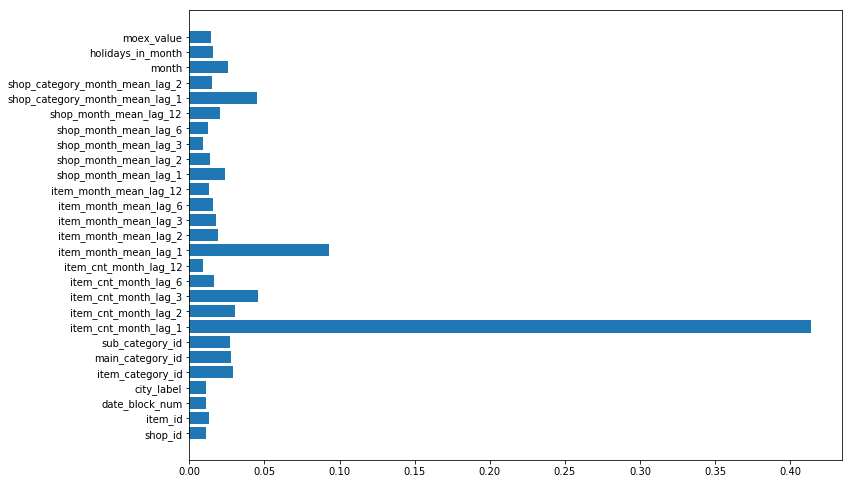

In [69]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

cols = new_train.drop('item_cnt_month', axis = 1).columns
plt.barh(cols, regressor_.feature_importances_)
plt.show()

In [70]:
submission['item_cnt_month'] = predictions
submission.to_csv('sales_sub.csv', index=False)
